# Distributed random-search hyper-parameter optimization of the Keras RPV classifier

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os

# External imports
import ipyparallel as ipp
import numpy as np
import keras
import matplotlib.pyplot as plt

# Local imports
from rpv import load_dataset

/usr/common/software/tensorflow/intel-tensorflow/1.8.0-py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Connect to cluster

In [2]:
# Use default profile for now
c = ipp.Client()
print('Worker IDs:', c.ids)

Worker IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [3]:
# Data config
n_train = 64000 #412416
n_valid = 32000 #137471
n_test = 32000 #137471
input_dir = '/global/cscratch1/sd/sfarrell/atlas-rpv-images'

In [4]:
((train_input, train_labels, train_weights),
 (valid_input, valid_labels, valid_weights),
 (test_input, test_labels, test_weights)) = load_dataset(input_dir, n_train, n_valid, n_test)

In [5]:
print('train shape:', train_input.shape, 'Mean label:', train_labels.mean())
print('valid shape:', valid_input.shape, 'Mean label:', valid_labels.mean())
print('test shape: ', test_input.shape, 'Mean label:', test_labels.mean())

train shape: (64000, 64, 64, 1) Mean label: 0.428734375
valid shape: (32000, 64, 64, 1) Mean label: 0.4258125
test shape:  (32000, 64, 64, 1) Mean label: 0.42690625


## Configure the hyper-parameter search tasks

In [6]:
# Temporarily making things reproducible for development
np.random.seed(0)

# Define the hyper-parameter search points
n_hpo_trials = 128
h1 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
h2 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
h3 = np.random.choice([8, 16, 32, 64, 128], size=n_hpo_trials)
conv_sizes = np.stack([h1, h2, h3], axis=1)
fc_sizes = np.random.choice([32, 64, 128, 256], size=(n_hpo_trials, 1))
lr = np.random.choice([0.0001, 0.001, 0.01], size=n_hpo_trials)
dropout = np.random.rand(n_hpo_trials)
optimizer = np.random.choice(['Adadelta', 'Adam', 'Nadam'], size=n_hpo_trials)

# Training config
batch_size = 64
n_epochs = 16
checkpoint_dir = '/global/cscratch1/sd/sfarrell/cori-interactive-dl/rpv_hpo'

## Run the hyper-parameter search

In [7]:
def build_and_train(train_input, train_labels, valid_input, valid_labels,
                    conv_sizes, fc_sizes, dropout, optimizer, lr,
                    batch_size, n_epochs, checkpoint_file=None, verbose=2):
    """Run training for one set of hyper-parameters.
    TODO: add support for model checkpointing."""
    from rpv import build_model, train_model
    # Build the model
    model = build_model(train_input.shape[1:],
                        conv_sizes=conv_sizes, fc_sizes=fc_sizes,
                        dropout=dropout, optimizer=optimizer, lr=lr)
    # Train the model
    history = train_model(model, train_input=train_input, train_labels=train_labels,
                          valid_input=valid_input, valid_labels=valid_labels,
                          batch_size=batch_size, n_epochs=n_epochs,
                          checkpoint_file=checkpoint_file, verbose=verbose)
    return history.history

In [8]:
# Load-balanced view
lv = c.load_balanced_view()

# Loop over hyper-parameter sets
results = []
for ihp in range(n_hpo_trials):
    print('Hyper-parameter trial', ihp)
    print('  Conv sizes', conv_sizes[ihp])
    print('  FC sizes', fc_sizes[ihp])
    print('  Dropout %.4f' % dropout[ihp])
    print('  Optimizer', optimizer[ihp])
    print('  LearningRate', lr[ihp])
    checkpoint_file = os.path.join(checkpoint_dir, 'model_%i.h5' % ihp)
    result = lv.apply(build_and_train,
                      train_input, train_labels, valid_input, valid_labels,
                      conv_sizes=conv_sizes[ihp], fc_sizes=fc_sizes[ihp],
                      dropout=dropout[ihp], optimizer=optimizer[ihp], lr=lr[ihp],
                      batch_size=batch_size, n_epochs=n_epochs,
                      checkpoint_file=checkpoint_file)
    results.append(result)

Hyper-parameter trial 0
  Conv sizes [64 16 32]
  FC sizes [32]
  Dropout 0.8287
  Optimizer Adadelta
  LearningRate 0.001
Hyper-parameter trial 1
  Conv sizes [  4  32 128]
  FC sizes [32]
  Dropout 0.9250
  Optimizer Adadelta
  LearningRate 0.01
Hyper-parameter trial 2
  Conv sizes [32  4 64]
  FC sizes [32]
  Dropout 0.0460
  Optimizer Adam
  LearningRate 0.0001
Hyper-parameter trial 3
  Conv sizes [32 64 64]
  FC sizes [32]
  Dropout 0.2326
  Optimizer Adadelta
  LearningRate 0.001
Hyper-parameter trial 4
  Conv sizes [32  4 16]
  FC sizes [32]
  Dropout 0.3485
  Optimizer Nadam
  LearningRate 0.01
Hyper-parameter trial 5
  Conv sizes [ 8  4 16]
  FC sizes [256]
  Dropout 0.8150
  Optimizer Adadelta
  LearningRate 0.001
Hyper-parameter trial 6
  Conv sizes [32 16 16]
  FC sizes [128]
  Dropout 0.9855
  Optimizer Adadelta
  LearningRate 0.01
Hyper-parameter trial 7
  Conv sizes [16 32 16]
  FC sizes [64]
  Dropout 0.9690
  Optimizer Adam
  LearningRate 0.001
Hyper-parameter trial 8


Hyper-parameter trial 116
  Conv sizes [ 8  8 16]
  FC sizes [64]
  Dropout 0.4103
  Optimizer Nadam
  LearningRate 0.001
Hyper-parameter trial 117
  Conv sizes [64  8 16]
  FC sizes [64]
  Dropout 0.6233
  Optimizer Adadelta
  LearningRate 0.01
Hyper-parameter trial 118
  Conv sizes [16 16  8]
  FC sizes [256]
  Dropout 0.8870
  Optimizer Adam
  LearningRate 0.01
Hyper-parameter trial 119
  Conv sizes [32  8 64]
  FC sizes [64]
  Dropout 0.6188
  Optimizer Adam
  LearningRate 0.01
Hyper-parameter trial 120
  Conv sizes [ 4 64  8]
  FC sizes [256]
  Dropout 0.1335
  Optimizer Adadelta
  LearningRate 0.001
Hyper-parameter trial 121
  Conv sizes [ 32  16 128]
  FC sizes [128]
  Dropout 0.9806
  Optimizer Adam
  LearningRate 0.001
Hyper-parameter trial 122
  Conv sizes [16 64 16]
  FC sizes [32]
  Dropout 0.8718
  Optimizer Adam
  LearningRate 0.001
Hyper-parameter trial 123
  Conv sizes [ 32  64 128]
  FC sizes [64]
  Dropout 0.5027
  Optimizer Nadam
  LearningRate 0.01
Hyper-parameter t

In [9]:
results

[<AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncResult: build_and_train>,
 <AsyncRes

In [10]:
histories = [ar.get() for ar in results]

In [11]:
ar = results[0]

In [12]:
ar.display_outputs()

Train on 64000 samples, validate on 32000 samples
Epoch 1/16
 - 93s - loss: 0.6929 - acc: 0.4882 - val_loss: 0.6930 - val_acc: 0.4836
Epoch 2/16
 - 92s - loss: 0.6926 - acc: 0.4667 - val_loss: 0.6926 - val_acc: 0.5588
Epoch 3/16
 - 92s - loss: 0.6923 - acc: 0.4669 - val_loss: 0.6922 - val_acc: 0.5728
Epoch 4/16
 - 92s - loss: 0.6919 - acc: 0.4816 - val_loss: 0.6920 - val_acc: 0.5741
Epoch 5/16
 - 92s - loss: 0.6916 - acc: 0.4959 - val_loss: 0.6917 - val_acc: 0.5742
Epoch 6/16
 - 92s - loss: 0.6912 - acc: 0.5113 - val_loss: 0.6915 - val_acc: 0.5742
Epoch 7/16
 - 92s - loss: 0.6910 - acc: 0.5231 - val_loss: 0.6912 - val_acc: 0.5742
Epoch 8/16
 - 92s - loss: 0.6907 - acc: 0.5335 - val_loss: 0.6910 - val_acc: 0.5742
Epoch 9/16
 - 92s - loss: 0.6903 - acc: 0.5409 - val_loss: 0.6908 - val_acc: 0.5742
Epoch 10/16
 - 92s - loss: 0.6901 - acc: 0.5459 - val_loss: 0.6906 - val_acc: 0.5742
Epoch 11/16
 - 92s - loss: 0.6899 - acc: 0.5504 - val_loss: 0.6904 - val_acc: 0.5742
Epoch 12/16
 - 92s - los

/usr/common/software/tensorflow/intel-tensorflow/1.8.0-py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model selection and evaluation

In [13]:
def draw_history(h):
    plt.figure(figsize=(9,4))
    # Loss
    plt.subplot(121)
    plt.plot(h['loss'], label='Training')
    plt.plot(h['val_loss'], label='Validation')
    plt.xlim(xmin=0, xmax=len(h['loss'])-1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    # Accuracy
    plt.subplot(122)
    plt.plot(h['acc'], label='Training')
    plt.plot(h['val_acc'], label='Validation')
    plt.xlim(xmin=0, xmax=len(h['loss'])-1)
    plt.ylim((0, 1))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.tight_layout()

In [14]:
%matplotlib notebook

In [15]:
last_scores = np.array([h['val_acc'][-1] for h in histories])
best_scores = np.array([max(h['val_acc']) for h in histories])

Hyperparameters: trial 20 conv [ 32  64 128] fc [256] dropout 0.379 opt Nadam, lr 0.001
  Last validation accuracy 0.9888
  Best validation accuracy 0.9892


<IPython.core.display.Javascript object>


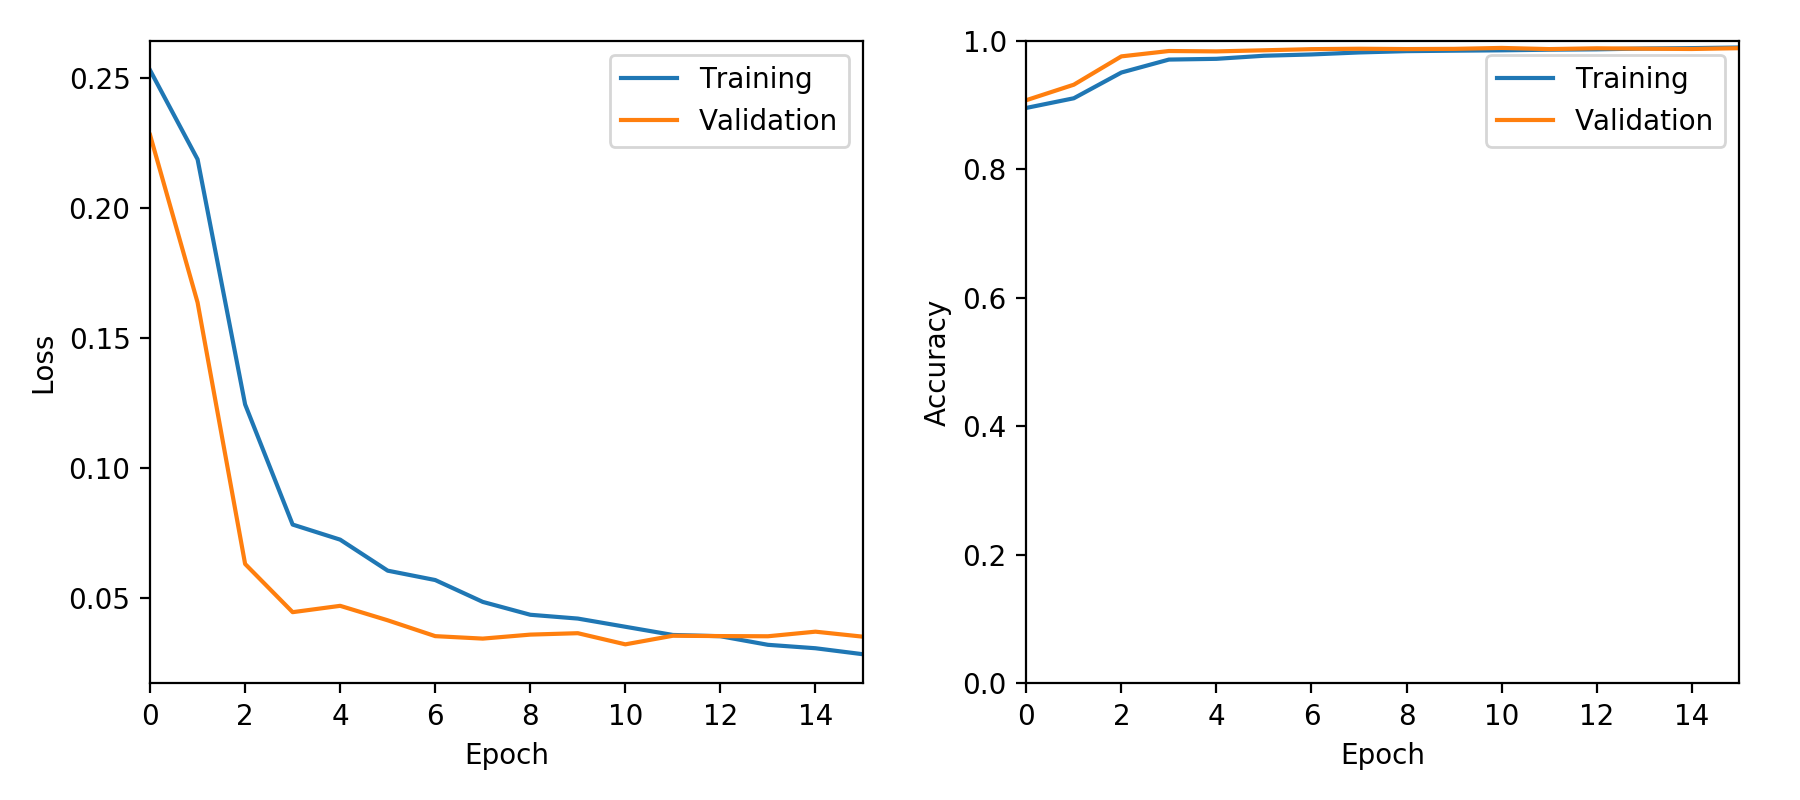

In [16]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmax()
print('Hyperparameters: trial %i conv %s fc %s dropout %.3f opt %s, lr %.3f' %
      (i, conv_sizes[i], fc_sizes[i], dropout[i], optimizer[i], lr[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])
draw_history(histories[i])

Hyperparameters: trial 53 conv [ 4  4 64] fc [32] dropout 0.552 opt Adadelta, lr 0.000
  Last validation accuracy 0.5707
  Best validation accuracy 0.5707


<IPython.core.display.Javascript object>


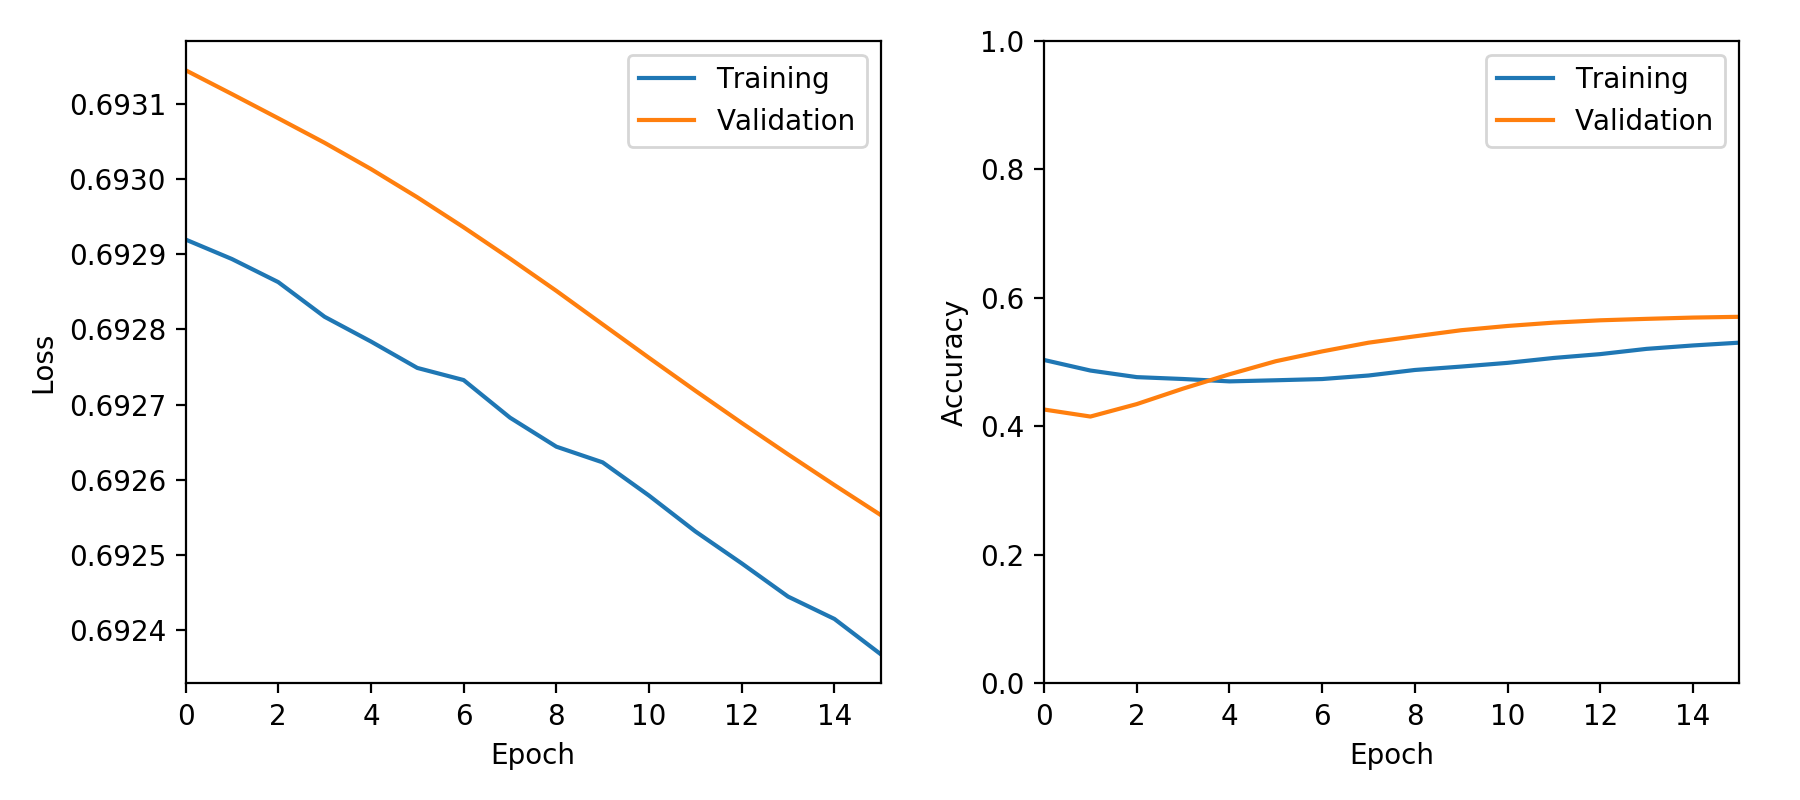

In [17]:
# Find the worst in terms of final validation set accuracy
i = best_scores.argmin()
print('Hyperparameters: trial %i conv %s fc %s dropout %.3f opt %s, lr %.3f' %
      (i, conv_sizes[i], fc_sizes[i], dropout[i], optimizer[i], lr[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])
draw_history(histories[i])

### Looking for trends in the best hyper-parameter sets

<IPython.core.display.Javascript object>


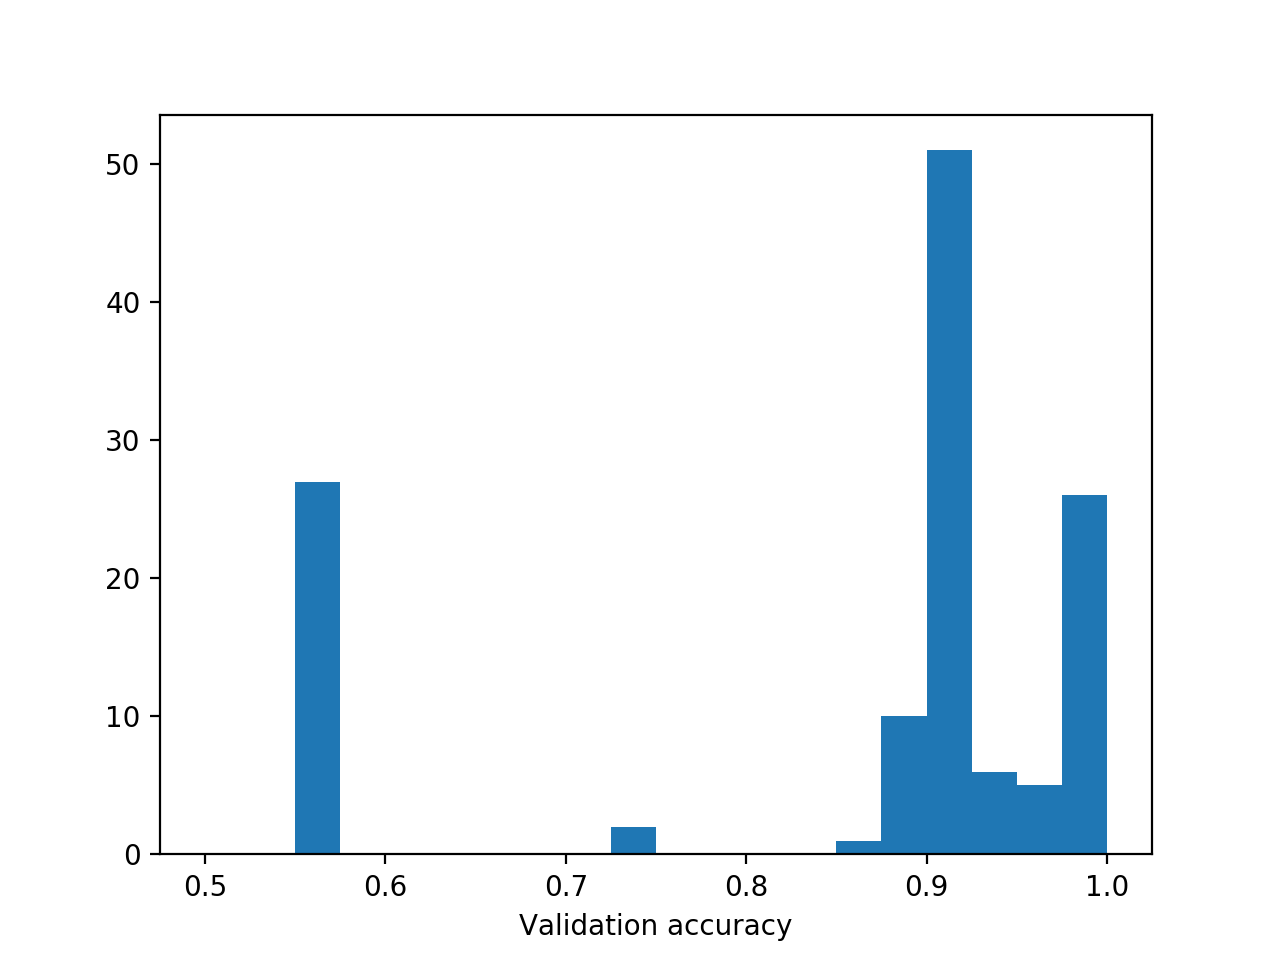

In [31]:
plt.figure()
plt.hist(best_scores, bins=20, range=(0.5, 1))
plt.xlabel('Validation accuracy');

In [39]:
for i in best_scores.argsort()[::-1][:5]:
    print('Hyperparameters: trial %i conv %s fc %s dropout %.3f opt %s, lr %.3f' %
          (i, conv_sizes[i], fc_sizes[i], dropout[i], optimizer[i], lr[i]))
    print('  Best validation accuracy %.4f' % best_scores[i])

Hyperparameters: trial 20 conv [ 32  64 128] fc [256] dropout 0.379 opt Nadam, lr 0.001
  Best validation accuracy 0.9892
Hyperparameters: trial 83 conv [32 64 16] fc [256] dropout 0.008 opt Adam, lr 0.001
  Best validation accuracy 0.9891
Hyperparameters: trial 89 conv [16 64  8] fc [256] dropout 0.024 opt Adam, lr 0.001
  Best validation accuracy 0.9889
Hyperparameters: trial 55 conv [  8  16 128] fc [256] dropout 0.455 opt Nadam, lr 0.001
  Best validation accuracy 0.9888
Hyperparameters: trial 99 conv [32  4  8] fc [256] dropout 0.003 opt Nadam, lr 0.001
  Best validation accuracy 0.9884


### Test set evaluation

Here we load the best selected model and evaluate final performance on the test set.

In [18]:
from sklearn import metrics

def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    #print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

def draw_roc(labels, outputs, weights=None, ax=None):
    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    auc = metrics.roc_auc_score(labels, outputs, sample_weight=weights)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='CNN, AUC=%.3f' % auc)
    ax.plot([0, 1], [0, 1], '--', label='Random')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc=0)

In [21]:
i = best_scores.argmax()
model_file = os.path.join(checkpoint_dir, 'model_%i.h5' % i)
model = keras.models.load_model(model_file)

In [22]:
test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)

In [23]:
# Unweighted results
print('Unweighted metrics')
summarize_metrics(test_labels, test_output)
print()

# Weighted results
print('Weighted metrics')
summarize_metrics(test_labels, test_output, weights=test_weights)

Unweighted metrics
Accuracy:   0.9878
Purity:     0.9849
Efficiency: 0.9865

Weighted metrics
Accuracy:   0.9686
Purity:     0.0019
Efficiency: 0.9865


<IPython.core.display.Javascript object>


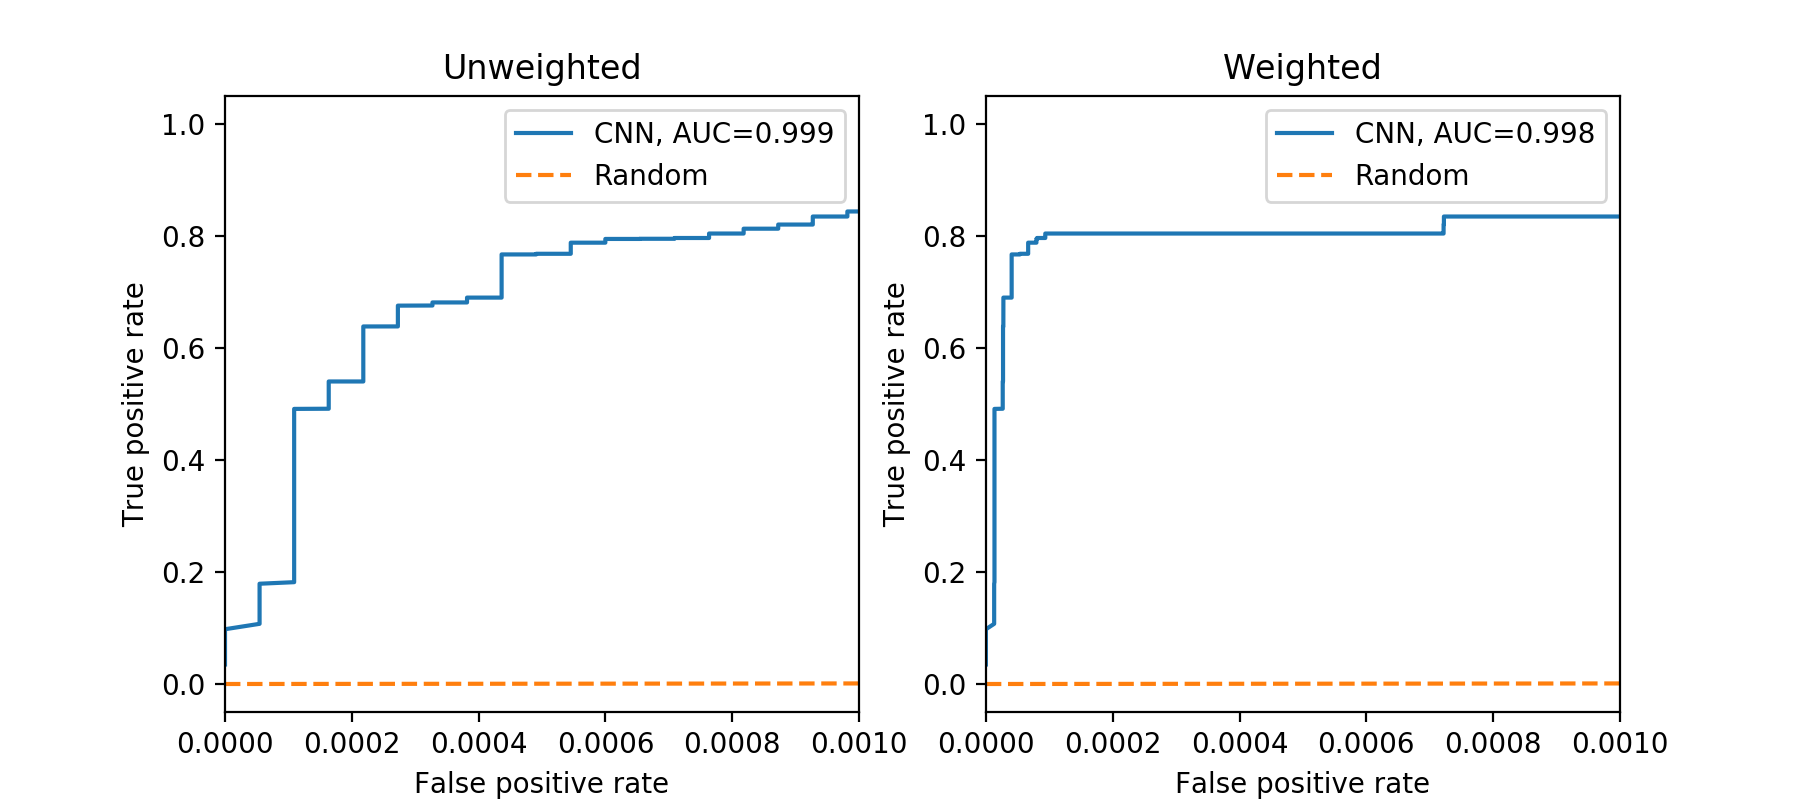

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
draw_roc(test_labels, test_output, ax=axs[0])
draw_roc(test_labels, test_output, ax=axs[1], weights=test_weights)
axs[0].set_xlim([0, 0.001])
axs[0].set_title('Unweighted')
axs[1].set_xlim([0, 0.001])
axs[1].set_title('Weighted');